# Uniswap calculation

This notebook is available at http://ai.hkphysics.hk/ username: user

This uses a modified uniswappy which is available on branch main at https://github.com/hkphysics/uniswappy

See

https://blog.uniswap.org/uniswap-v3-math-primer

https://atiselsts.github.io/pdfs/uniswap-v3-liquidity-math.pdf

https://medium.com/@icmoore/simulating-a-liquidity-pool-for-decentralized-finance-6f357ec8564b

In [1]:
# set up calculations

from uniswappy import *
import pandas as pd
import numpy as np
from icecream import ic
from dataclasses import dataclass
import traceback
from axc_lp import *

fee = UniV3Utils.FeeAmount.MEDIUM
tick_spacing = UniV3Utils.TICK_SPACINGS[fee]
init_price = UniV3Utils.encodePriceSqrt(1000,1000)

usdt_in = 10**6
tenv = TokenScenario(
    user = 'user',
    user_lp = 10000,
    reserve = usdt_in * 0.2,
    name0 = "TKN",
    name1 = "USDT",
    address0 = "0x111",
    address1 = "0x09",   
    usdt_in = usdt_in,
    tick_spacing = tick_spacing,
    fee = fee,
    init_price = init_price,
    nav=1.0,
    reserve_lower = 0.9,
    seed  = 42
)



This calculation puts all of the reserve into a liquidity pool between 1.0 and lower bound

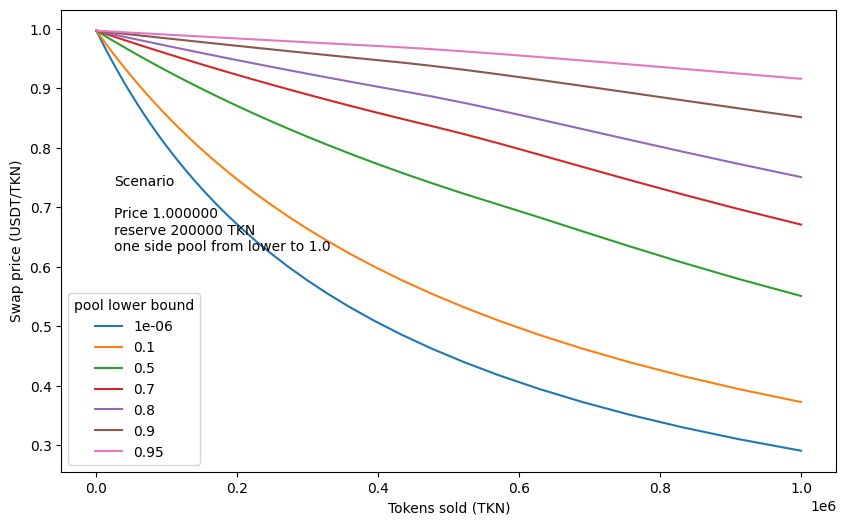

In [2]:
results = do_calc(tenv)
results
plotme(results,'pool lower bound', """Scenario

Price %f
reserve %d TKN
one side pool from lower to 1.0
""" % (1.0, tenv.reserve))

This compute takes the reserve and puts most of it into a v2 style LP but reserves a fraction into an insurance pool

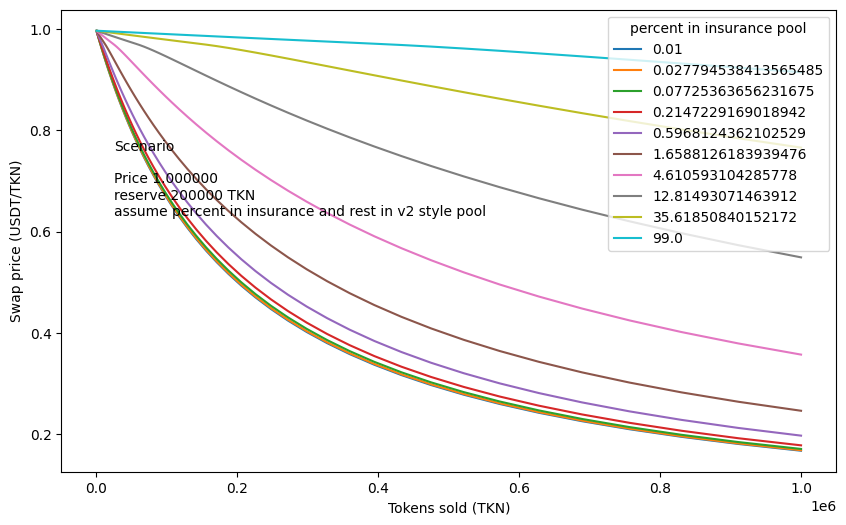

In [3]:
results = do_calc1(tenv)
plotme(results, 'percent in insurance pool', """Scenario

Price %f
reserve %d TKN
assume percent in insurance and rest in v2 style pool
""" % (1.0, tenv.reserve))

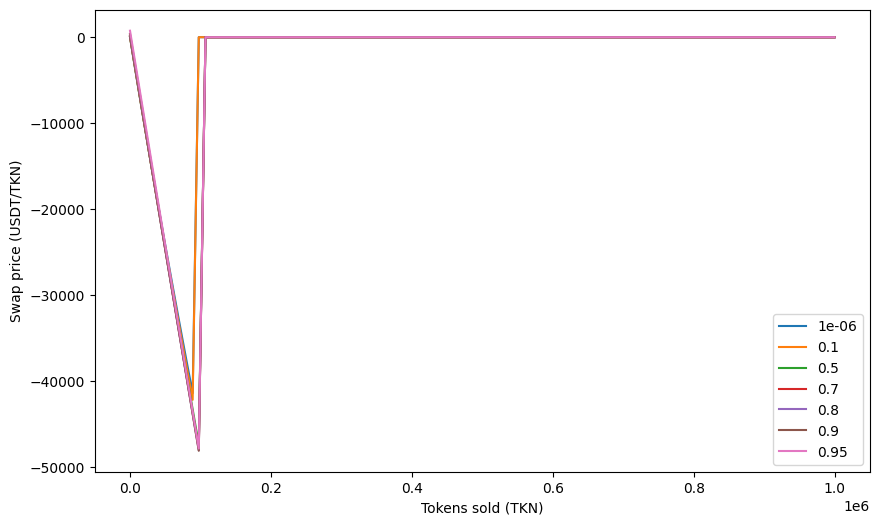

In [5]:
import matplotlib.pyplot as plt

def do_calc2(tenv):
    results = []
    for lower in [0.95, 0.9, 0.8, 0.7, 0.5, 0.1, 0.000001]:
        for swap in np.geomspace(100, tenv.usdt_in, num=100):
            (lp, tkn0, tkn1) = setup_lp(tenv, [
                [
                    tenv.user_lp, "min_tick", "max_tick"
                ],
                [
                tenv.reserve, lower, 1.0
            ]])
            solver = SolveDeltas(lp)
            try:
                out = Swap().apply(lp, tkn0, tenv.user, swap)
                (x, y) = solver.calc(0.9998)
                results.append({
                    "lower": lower,
                    "swap": swap,
                    "out": out,
                    "price": float(out) / float(swap),
                    "x": x,
                    "y": y
                })
            except AssertionError:
                pass
    return pd.DataFrame(results)

def plotme2(df, title, annotation):
    plt.figure(figsize=(10,6))
    for key, grp in df.groupby('lower'):
        plt.plot(grp['swap'], grp['y'], label=key)

    plt.text(25000, 0.6, annotation )
    plt.legend(title=title)
    plt.xlabel('Tokens sold (TKN)')
    plt.ylabel('Swap price (USDT/TKN)')
    plt.show()

results = do_calc2(tenv)
plotme2(results, "", "")